In [81]:
import numpy as np

# Input: sequence of images: b/w
def create_input(l=32,b=48,t=48):
    # creates input of shape (t,l,b)
    input = np.zeros((t,l,b),dtype=np.bool)
    for i in range(t):
        input[i,:,(i*l)//t]=True
    return input

def delay(x,tau,dt):
    #print(np.shape(x))
    a,t_max = np.shape(x)
    output = np.zeros((a,t_max))
    for i in range(t_max-1):
        output[:,i+1] = x[:,i]+output[:,i]-output[:,i]/tau*dt
    return output

def medulla(input,tau,dt):
    # input from pair of ommatidia to HR detector pair. Shape: (2,t)
    _,t=np.shape(input)
    output = np.zeros((4,t))

    output[0,:] = np.sum(delay(input[0:-1,:],tau['1'],dt)*delay(input[1:,:],tau['b'],dt),0)
    output[1,:] = np.sum(delay(input[0:-1,:],tau['b'],dt)*delay(input[1:,:],tau['1'],dt),0)
    output[2,:] = np.sum(delay(input[0:-1,:],tau['2'],dt)*delay(input[1:,:],tau['b'],dt),0)
    output[3,:] = np.sum(delay(input[0:-1,:],tau['b'],dt)*delay(input[1:,:],tau['2'],dt),0)
    #prog_tau
    #reg_tau
    #tau_s = 
    return output

def lobulla(input):
    # input shape: (l*b//2,4,t)
    sum_out = np.sum(input, axis=0)
    return np.concatenate(([sum_out[0]-sum_out[1]],[sum_out[2]-sum_out[3]]),axis=0)   # shape: (2,t)

#def AVDU # TODO Vibhu :)

(10, 100)


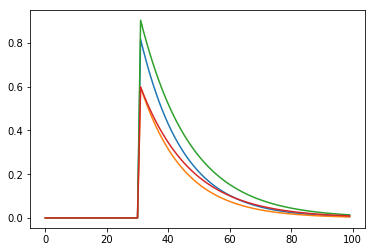

In [82]:
x=np.zeros((10,100))
x[1,20]=1
x[2,30]=1
print(np.shape(x))
tau={'1':5,'2':10,'b':2}
tau['1']=5
tau['2']=10
tau['b']=2
a=medulla(x,tau,0.1)
import matplotlib.pyplot as plt
#plt.plot(delay(x,10,0.1)[1,:])
plt.plot(np.transpose(a))

In [44]:
np.shape(lobulla(np.zeros((3,4,5))))

(2, 5)

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# Input: video - sequence of images: b/w
# def create_input(l=32,b=48,t=48):
#     # creates input of shape (l,b,t)
#     input = np.zeros((l,b,t),dtype=np.bool)
#     for i in range(t):
#         input[:,(i*l)//t,i]=True
#     return input

def delay(x,tau):
    dt = 0.1
    output = np.zeros_like(x)
    for i in range(len(x)-1):
        output[i+1] = x[i]+output[i]-output[i]/tau*dt
    return output

def medulla(input,tau):
    # input from pair of ommatidia to HR detector pair. Shape: (2,t)
    output = np.zeros((4,np.shape(input)[1]))
    #print(np.shape(input))
    output[0,:] = delay(input[0],tau['1'])*delay(input[1],tau['b'])
    output[1,:] = delay(input[0],tau['b'])*delay(input[1],tau['1'])
    output[2,:] = delay(input[0],tau['2'])*delay(input[1],tau['b'])
    output[3,:] = delay(input[0],tau['b'])*delay(input[1],tau['2'])
    
    return output  #(4,t)

def lobulla(input):
    # input shape: (l//2,4,t)
    sum_out = np.sum(input, axis=0)     # (4,t)
    lob_out = (sum_out[0]-sum_out[1])+(sum_out[2]-sum_out[3]+1e-8) # (1,t)
    return sum_out, lob_out

def AVDU(sum_out,lob_out,tau):  # sum_out: (4,t), lob_out: (1,t)
    avdu_out = np.zeros((2,len(lob_out)))
    avdu_out[0] = sum_out[0]/(sum_out[2]+1e-8) - delay(lob_out,tau['s'])       # 1e-8 for stability
    avdu_out[1] = sum_out[1]/(sum_out[3]+1e-8) + delay(lob_out,tau['s'])
    avdu_out[0] = delay(avdu_out[0],tau['s'])
    avdu_out[1] = delay(avdu_out[1],tau['s'])
    
    return avdu_out

def process_input(angular_velocity = 1000):
    l = 48
    b = 32
    dt=1e-5
    t_end = 2*360/angular_velocity
    t = np.arange(0,t_end,dt)
    tau={'1':5,'2':15,'b':1,'s':10}   # in ms
    
    input = create_input(angular_velocity,t)
    med_out = np.zeros((l//2,4,len(t)))
    
    #for i in range(l):
    for j in range(l//2):
        #print(j,np.shape(input[i,2*j:2*j+2,:]))
        med_out[j,:,:] = b*medulla(input[2*j:2*j+2,:],tau)

        #print(input[i,2*j:2*j+2,:])

    sum_out, lob_out = lobulla(med_out)   # sum_out for posititional features (landmarks), lob_out for AVDU inputs (motion)
    avdu_out = AVDU(sum_out,lob_out,tau)
    
    pos_out = np.zeros((16,len(t)))
    for i in range(0,l,l//16):
        #print(i/l*16)
        pos_out[int(i/l*16),:] = np.sum(input[i:i+l//16,:],axis=0)
    #plt.plot(np.sum(input[l//16:l//16+l//16,:],axis=0))
    #plt.plot(pos_out[1,:])
    return  pos_out, avdu_out

In [181]:
pos_out, avdu_out = process_input(5000)

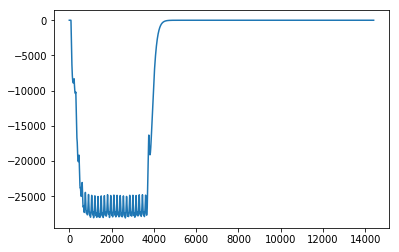

In [183]:
plt.plot(avdu_out[0,:])


(48, 720)


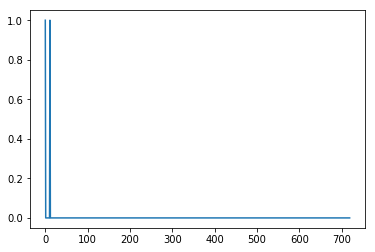

In [160]:
import numpy as np

def create_input(angular_velocity,t, bar_width=11.5,  H=48, V=32, field = 180):
    ommatidia_field = field/H
    dt = t[1]-t[0]
    bar = np.zeros((H,len(t)))
    for i in range(H):
        bar[i,int(i*(ommatidia_field/angular_velocity)/dt)] = 1
        #print(i*(ommatidia_field/angular_velocity)/dt)
        #print(i/dt*ommatidia_field/angular_velocity+(bar_width/angular_velocity)/dt)
        bar[i,int(i/dt*ommatidia_field/angular_velocity+(bar_width/angular_velocity)/dt)] = 1
    return bar
angular_velocity = 10000
dt=1e-4
t_end = 2*360/angular_velocity
t = np.arange(0,t_end,dt)
a = create_input(angular_velocity,t)
#print(a[0,0,:])
print(np.shape(a))
import matplotlib.pyplot as plt
#plt.plot(delay(x,10,0.1)[1,:])
plt.plot(np.transpose(a[0,:]))  
#plt.plot(np.transpose(a[1,0,:]))
#plt.plot(np.transpose(a[2,0,:]))    
